In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

In [6]:
def get_acc(model, mode, shot, task_id, metric, misleading):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['misleading'] == misleading)
    ]
    
    if len(run_df):
        # check whether it is nan or not
        if np.isnan(float(run_df[metric].iloc[0])):
            print(run_df[metric])
            return run_df
        else:
            if 'clip' in metric:
                return float(run_df[metric].iloc[0])
            else:
                return float(run_df[metric].item())/1000            
    else:
        return 0

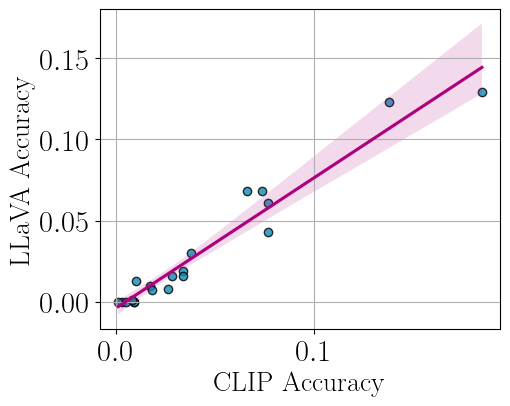

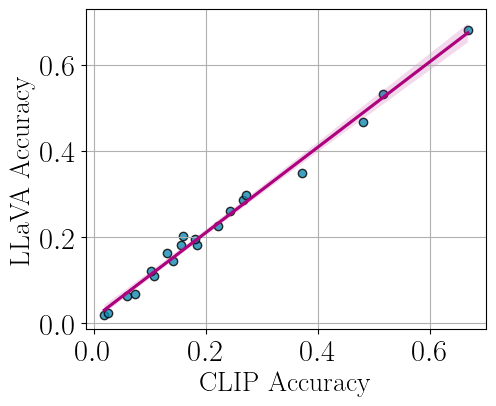

In [7]:
for mode in ['text', 'image']:
    acc_dict = {'clip': [], 'llava': []}
    for task_id in range(1, 11):
        for misleading in [0,1]:
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'clip_correct', 
                misleading = misleading,
            )
            acc_dict['clip'].append(acc)
            
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'overall', 
                misleading = misleading,
            )
            acc_dict['llava'].append(acc)
            
    acc_df = pd.DataFrame(acc_dict)

    # Plot with a regression line and confidence interval
    plt.rc('font', family='serif', serif='times new roman')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

    lw = 2.5
    markers = ['s', 'o']
    colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
    models = ['Emu', 'SEED-LLaMA', 'GILL']
    lts = ['--', '-']
    marker_sizes = [6, 5]
    shots = [1,2,4]

    fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
    fig.subplots_adjust(left=0.18, bottom=.18, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
    fig.set_size_inches(5, 4) #exact size of the figure
    sns.regplot(x=acc_df['clip'], y=acc_df['llava'], ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

    # plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
    plt.xlabel('CLIP Accuracy', fontsize = 20)
    plt.ylabel('LLaVA Accuracy', fontsize = 20)
    plt.grid(True)
    fig.savefig(f'{root_dir}/figures/clip_llava_{mode}.pdf')
    plt.show()
            

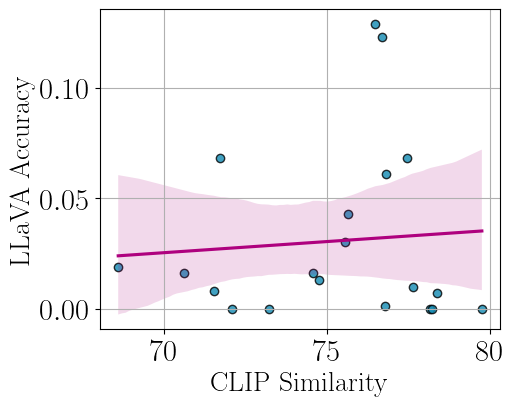

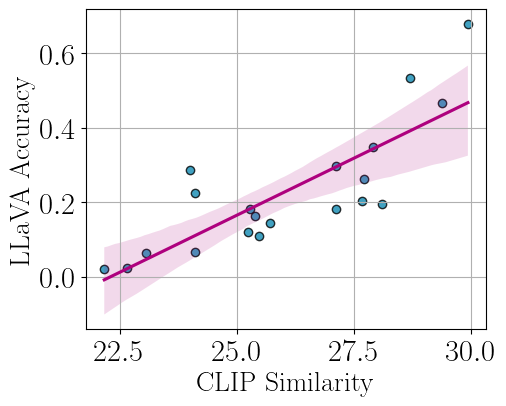

In [9]:
for mode in ['text', 'image']:
    acc_dict = {'clip': [], 'llava': []}
    for task_id in range(1, 11):
        for misleading in [0,1]:
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'clip_similarity_overall', 
                misleading = misleading,
            )
            acc_dict['clip'].append(acc)
            
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'overall', 
                misleading = misleading,
            )
            acc_dict['llava'].append(acc)
            
    acc_df = pd.DataFrame(acc_dict)

    # Plot with a regression line and confidence interval
    plt.rc('font', family='serif', serif='times new roman')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

    lw = 2.5
    markers = ['s', 'o']
    colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
    models = ['Emu', 'SEED-LLaMA', 'GILL']
    lts = ['--', '-']
    marker_sizes = [6, 5]
    shots = [1,2,4]

    fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
    fig.subplots_adjust(left=0.18, bottom=.18, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
    fig.set_size_inches(5, 4) #exact size of the figure
    sns.regplot(x=acc_df['clip'], y=acc_df['llava'], ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

    # plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
    plt.xlabel('CLIP Similarity', fontsize = 20)
    plt.ylabel('LLaVA Accuracy', fontsize = 20)
    plt.grid(True)
    fig.savefig(f'{root_dir}/figures/clip_similarity_llava_{mode}.pdf')
    plt.show()
            